In [1]:
# Importing libraries for audio, data handling, model training, etc.
import os
import glob
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

In [3]:
# Sampling rate and MFCC settings
SAMPLE_RATE = 22050
N_MFCC = 40
MAX_LEN = 173  # Frames to pad/truncate all MFCCs to the same shape

# 🎭 RAVDESS emotion label mapping (from filename code to actual emotion)
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [11]:
# This function loads each WAV file, extracts MFCCs, pads them to fixed length
def extract_features(directory):
    features, labels = [], []

    for path in glob.glob(os.path.join(directory, 'Actor_*/*.wav')):
        file_name = os.path.basename(path)
        emotion_code = file_name.split('-')[2]  # 3rd part of name is emotion
        emotion = emotion_map.get(emotion_code)

        # Load the audio signal
        signal, sr = librosa.load(path, sr=SAMPLE_RATE)

        # Extract MFCC features (40 coefficients)
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=N_MFCC)

        # Normalize MFCC: zero mean and unit variance
        ####### mfcc = (mfcc - np.mean(mfcc)) / np.std(mfcc)

        # Pad or truncate MFCCs to fixed length
        if mfcc.shape[1] < MAX_LEN:
            pad = MAX_LEN - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad)), mode='constant')
        else:
            mfcc = mfcc[:, :MAX_LEN]

        features.append(mfcc)
        labels.append(emotion)

    return np.array(features), np.array(labels)

In [12]:
# Wrap MFCCs + labels into a PyTorch Dataset
class MFCCDataset(Dataset):
    def __init__(self, features, labels):
        self.X = torch.tensor(features, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
        self.le = LabelEncoder()
        self.y = torch.tensor(self.le.fit_transform(labels), dtype=torch.long)
        self.class_names = self.le.classes_

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [13]:
# A basic Convolutional Neural Network for MFCC image-like inputs
class EmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 5 * 21, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)


In [42]:
# Alternative CNN
class EmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 5 * 21, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [45]:
# Function to train the model
def train_model(model, train_loader, val_loader, epochs=700):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for X, y in train_loader:
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

        # Validation accuracy
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                preds = model(X).argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)
        print(f"Validation Accuracy: {correct / total:.2f}")


In [46]:
# STEP 1: Set the path to the unzipped dataset
dataset_path = 'C:\\Users\\amel_\\Downloads\\Audio_Speech_Actors_01-24'

# STEP 2: Extract MFCC features
print("Extracting features...")
X, y = extract_features(dataset_path)
print(f"Extracted {len(X)} samples.")

# STEP 3: Create dataset and split into train/test
dataset = MFCCDataset(X, y)
train_len = int(0.8 * len(dataset))
val_len = len(dataset) - train_len
train_set, val_set = random_split(dataset, [train_len, val_len])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)

# STEP 4: Create and train the model
model = EmotionCNN(num_classes=len(dataset.class_names))
train_model(model, train_loader, val_loader)

# STEP 5: Final evaluation on validation set
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        outputs = model(X_batch)
        predictions = outputs.argmax(dim=1)
        y_true.extend(y_batch.tolist())
        y_pred.extend(predictions.tolist())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.class_names))



Extracting features...
Extracted 1440 samples.
Epoch 1, Loss: 2.0554
Validation Accuracy: 0.24
Epoch 2, Loss: 1.9135
Validation Accuracy: 0.31
Epoch 3, Loss: 1.8220
Validation Accuracy: 0.40
Epoch 4, Loss: 1.7342
Validation Accuracy: 0.38
Epoch 5, Loss: 1.6790
Validation Accuracy: 0.42
Epoch 6, Loss: 1.5956
Validation Accuracy: 0.41
Epoch 7, Loss: 1.5543
Validation Accuracy: 0.44
Epoch 8, Loss: 1.5006
Validation Accuracy: 0.45
Epoch 9, Loss: 1.4490
Validation Accuracy: 0.45
Epoch 10, Loss: 1.4461
Validation Accuracy: 0.45
Epoch 11, Loss: 1.3459
Validation Accuracy: 0.47
Epoch 12, Loss: 1.3231
Validation Accuracy: 0.48
Epoch 13, Loss: 1.2619
Validation Accuracy: 0.50
Epoch 14, Loss: 1.2295
Validation Accuracy: 0.53
Epoch 15, Loss: 1.1888
Validation Accuracy: 0.57
Epoch 16, Loss: 1.1512
Validation Accuracy: 0.56
Epoch 17, Loss: 1.0864
Validation Accuracy: 0.58
Epoch 18, Loss: 1.0751
Validation Accuracy: 0.56
Epoch 19, Loss: 1.0148
Validation Accuracy: 0.56
Epoch 20, Loss: 0.9869
Validati

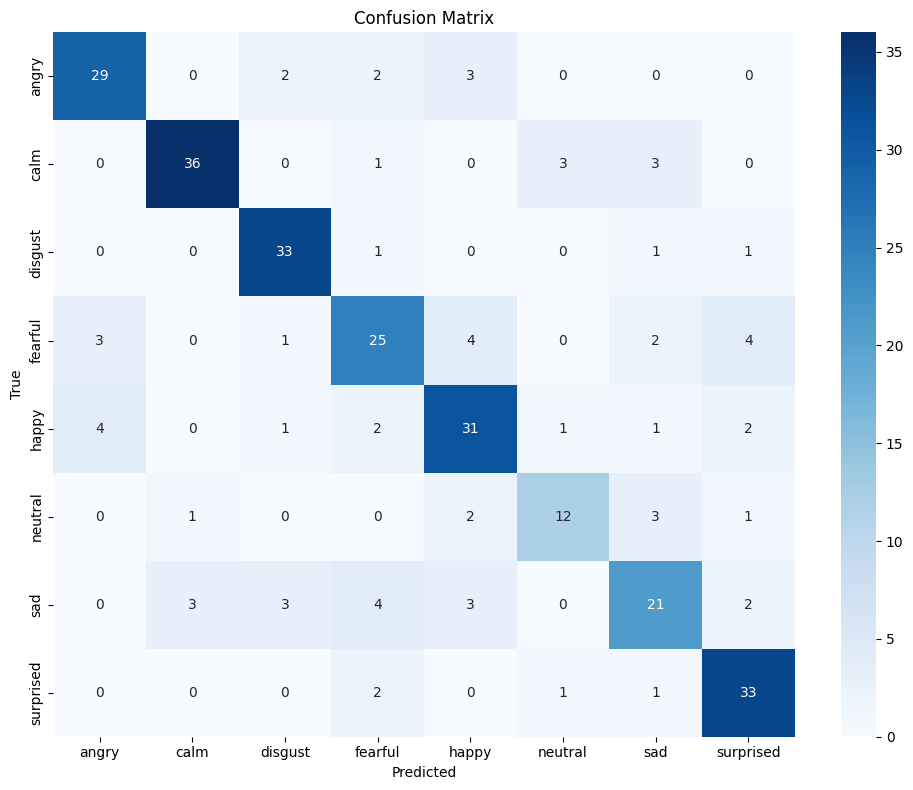

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dataset.class_names, 
            yticklabels=dataset.class_names)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
